In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader


# Hyperparameters

IMAGE_SIZE = 32
BATCH_SIZE = 64


# Transform: [0,1] -> [-1,1]
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.5, 0.5, 0.5),
        std=(0.5, 0.5, 0.5)
    )
])


train_dataset = torchvision.datasets.CIFAR10(
    root="./data",
    train=True,
    transform=transform,
    download=True
)


train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    drop_last=True,
    pin_memory=True   
)

print("Total Images:", len(train_dataset))


Total Images: 50000


In [7]:
import torch
import torchvision
import matplotlib.pyplot as plt

In [13]:
import matplotlib.pyplot as plt

def show_images(dataset, num_samples=20, cols=4):
    plt.figure(figsize=(15, 15))
    for i in range(num_samples):
        img, _ = dataset[i]     
        img = (img + 1) / 2     
        img = img.permute(1, 2, 0)  

        plt.subplot(num_samples // cols + 1, cols, i + 1)
        plt.imshow(img)
        plt.axis("off")

    plt.show()


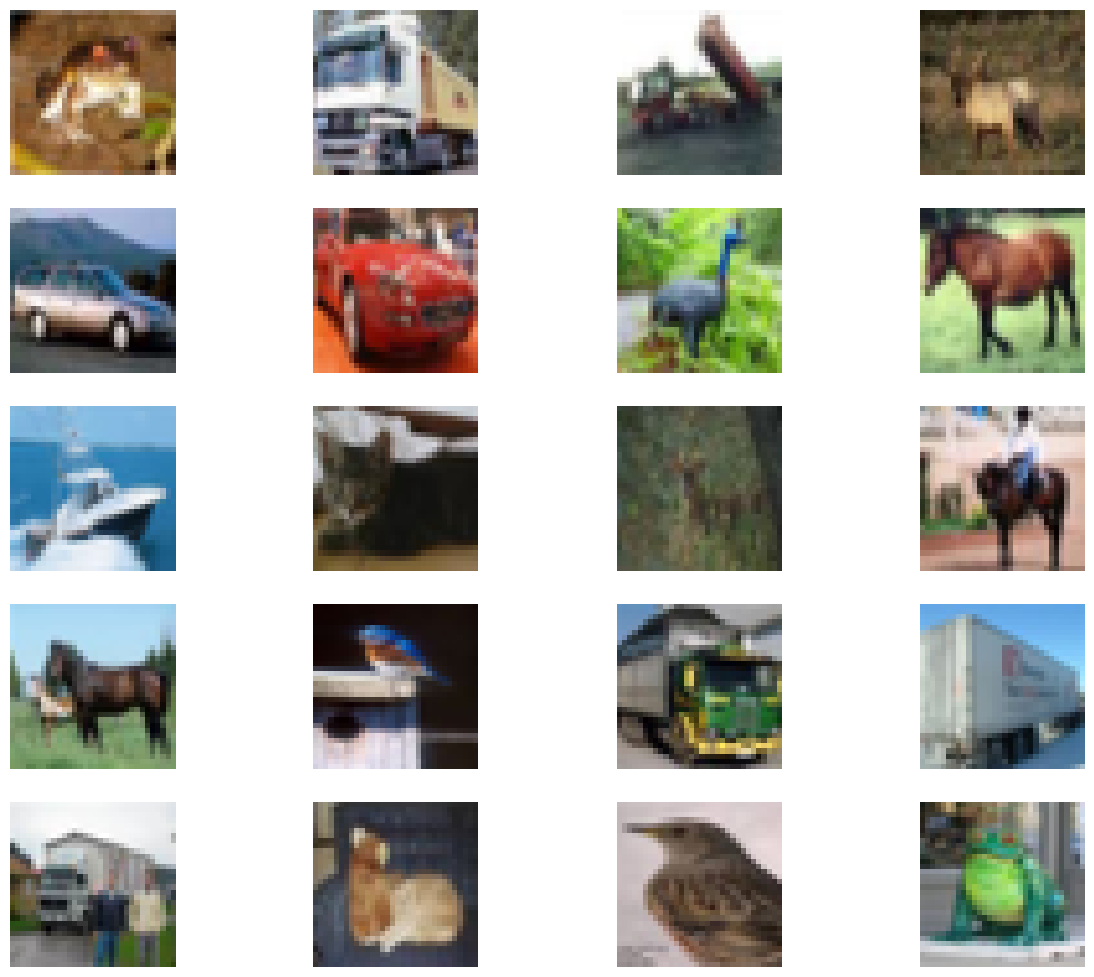

In [14]:
show_images(train_dataset)
